# HW02 Code

### Name: Mattia Danese

You will complete the following notebook, as described in the PDF for Homework 02 (included in the download with the starter code).  You will submit:
1. This notebook file, along with your COLLABORATORS.txt file, to the Gradescope link for code.
2. A PDF of this notebook and all of its output, once it is completed, to the Gradescope link for the PDF.  (This can be generated by printing the notebook as PDF, or using the **File -> Download as** menu.)


Please report any questions to the [class Piazza page](https://piazza.com/tufts/spring2021/comp135/home).

In [12]:
# import libraries as needed
import numpy as np
import pandas as pd
import math

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

### Plotting function

**Do not modify the following**: it takes in a list of polynomial (integer) values, along with associated lists consisting of the predictions made for the associated model, and the resulting error, and plots the results in a grid.

In [13]:
def plot_predictions(polynomials=list(), prediction_list=list(), error_list=list()):
    '''Plot predicted results for a number of polynomial regression models
    
    Args
    ----
    polynomials : list of positive integer values
        Each value is the degree of a polynomial regression model.
    prediction_list: list of arrays ((# polynomial models) x (# input data))
        Each array contains the predicted y-values for input data.
    error_list: list of error values ((# polynomial models) x 1)
        Each value is the mean squared error (MSE) of the model with 
        the associated polynomial degree.
    
        Note: it is expected that all lists are of the same length, and 
            that this length be some perfect square (for grid-plotting).
    '''
    length = len(prediction_list)
    grid_size = int(math.sqrt(length))
    if not (length == len(polynomials) and length == len(error_list)):
        raise ValueError("Input lists must be of same length")
    if not length == (grid_size * grid_size):
        raise ValueError("Need a square number of list items (%d given)" % (length))
    
    fig, axs = plt.subplots(grid_size, grid_size, figsize =(14,14), sharey=True)
    for subplot_id, prediction in enumerate(prediction_list):
        # order data for display
        data_frame = pd.DataFrame(data=[x[:, 0], prediction]).T
        data_frame = data_frame.sort_values(by=0)
        x_sorted = data_frame.iloc[:, :-1].values
        prediction_sorted = data_frame.iloc[:, 1].values

        ax = axs.flat[subplot_id]
        ax.set_title('degree = %d; MSE = %.3f' % (polynomials[subplot_id], error_list[subplot_id]))
        ax.plot(x, y, 'r.')
        ax.plot(x_sorted, prediction_sorted, color='blue')
        
    plt.show()

### Load the dataset

In [14]:
data = pd.read_csv('data.csv')
data

,x_i,y_i
0,1.590909,2.846988
1,1.803030,2.959811
2,4.984848,13.041394
3,1.696970,3.971889
4,1.272727,2.454520
...,...,...
95,5.090909,11.537465
96,10.500000,10.381492
97,1.484848,2.683212
98,0.636364,1.437600


In [15]:
x = data.iloc[:, :-1].values
y = data.iloc[:, 1].values

### 1. Test a range of polynomial functions fit to the data

Fit models to data of polynomial degree $d \in \{1, 2, 3, 4, 5, 6, 10, 11, 12\}$.  For each such model, we will record its predictions on the input data, along with the mean squared error (MSE) that it makes.  These results are then plotted for comparison.

#### 1.1 Create function to generate models, make predictions, measure error.

In [16]:
def test_polynomials(polynomials=list()):
    '''Generates a series of polynomial regression models on input data.
       Each model is fit to the data, then used to predict values of that
       input data.  Predictions and mean squared error are collected and
       returned as two lists.
    
    Args
    ----
    polynomials : list of positive integer values
        Each value is the degree of a polynomial regression model, to be built.
    
    Returns
    -------
    prediction_list: list of arrays ((# polynomial models) x (# input data))
        Each array contains the predicted y-values for input data.
    error_list: list of error values ((# polynomial models) x 1)
        Each value is the mean squared error (MSE) of the model with 
        the associated polynomial degree.
    '''
    prediction_list = list()
    error_list = list()
   
    # TODO: fill in this function to generate the required set of models,
    #       returning the predictions and the errors for each.
    
    
    for d in polynomials:
        poly = PolynomialFeatures(degree = d)
        transformed_x = poly.fit_transform(x)
        
        model = linear_model.LinearRegression()
        model.fit(transformed_x, y)
        
        yPredict = model.predict(transformed_x)

        prediction_list.append(yPredict)
        error_list.append(mean_squared_error(y, yPredict))
        
    return prediction_list, error_list
    

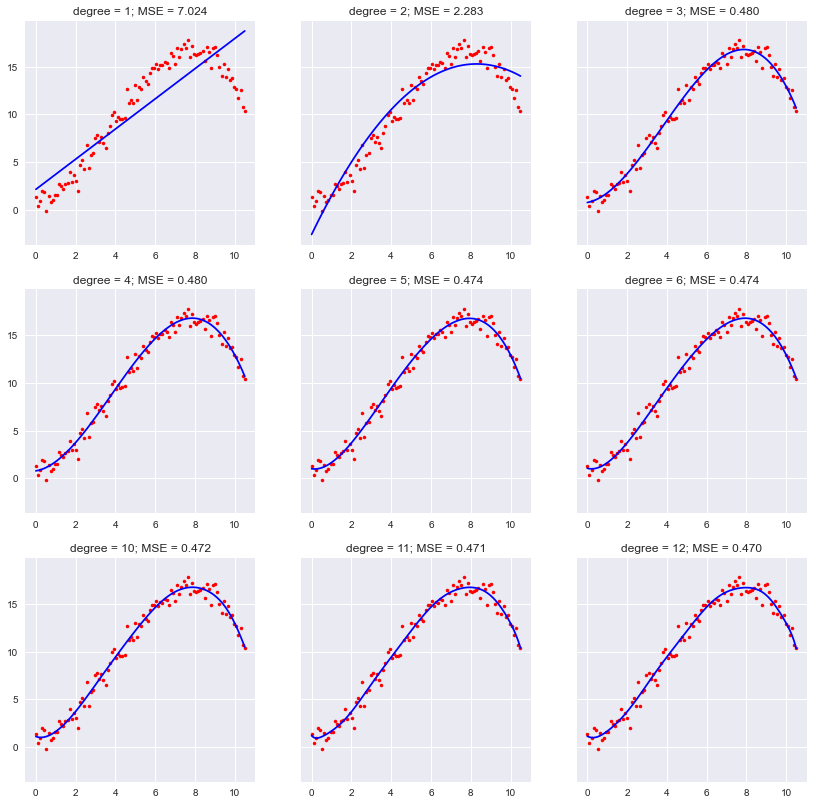

In [17]:
# TODO: generate the sequence of degrees, call test_polynomials to create models,
#       use plot_predictions to show the results
prediction_list, error_list = test_polynomials((1,2,3,4,5,6,10,11,12))

plot_predictions((1,2,3,4,5,6,10,11,12), prediction_list, error_list)

#### 1.2 Discuss the results seen in the plots above

**Discussion**:  The results show that the degree-12 model is the best, soley based on MSE. The models that do particularly poorly are the degree-1 and degree-2 models, as they have the highest MSE's by far. This tells us that the data does not express linear or quadratic distribution.

### 2. $k$-fold cross-validation 

For each of the polynomial degrees, 5-fold cross-validation is performed.  Data is divided into 5 equal parts, and 5 separate models are trained and tested.  Results are averaged over the 5 runs and plotted (in a single plot), comparing training and test error for each of the polynomial degrees.  Error values are also shown in a tabular form.

#### 2.1 Creating the $k$ folds

A function that generates the distinct, non-overlapping folds of the data.

In [27]:
def make_folds(num_folds=1):
    '''Splits data into num_folds separate folds for cross-validation.
       Each fold should consist of M consecutive items from the
       original data; each fold should be the same size (we will assume 
       that  the data divides evenly by num_folds).  Every data item should 
       appear in exactly one fold.
       
       Args
       ----
       num_folds : some positive integer value
           Number of folds to divide data into.
           
        Returns
        -------
        x_folds : list of sub-sequences of original x-data 
            There will be num_folds such sequences; each will 
            consist of 1/num_folds of the original data, in
            the original order.
        y_folds : list of sub-sequences of original y data
            There will be num_folds such sequences; each will 
            consist of 1/num_folds of the original data, in
            the original order.
       '''
    x_folds = list()
    y_folds = list()
        
    x_data = x.copy()
    y_data = y.copy()
    
    data_length = len(x_data)
    fold_length = math.floor(data_length / num_folds)
    # print(type(fold_length))
    
    idx = 0
    xs = []
    ys = []
    for i in range(data_length):
        xs.append(x_data[i])
        ys.append(y_data[i])
        
        if (i % fold_length == fold_length - 1):
            x_folds.append(xs)
            y_folds.append(ys)
            
            xs = []
            ys = []
            idx+=1
    
    return x_folds, y_folds

In [29]:
# Print out start/end of each fold for sanity check.  Should see 5 folds,
# with the (x,y) pairs at the start/end of each.  (Can be manually verified 
# by looking at original input file.)
#
# DO NOT MODIFY THIS CODE.  Its output will be used to check your work.
k = 5
x_folds, y_folds = make_folds(k)
for i in range(k):
    print("Fold %d: (%.3f, %.3f) ... (%.3f, %.3f)"
         % (i, x_folds[i][0], y_folds[i][0], x_folds[i][-1], y_folds[i][-1]))

Fold 0: (1.591, 2.847) ... (10.394, 10.739)
Fold 1: (6.788, 16.408) ... (2.227, 4.722)
Fold 2: (9.545, 13.897) ... (3.924, 10.229)
Fold 3: (2.864, 5.929) ... (7.212, 16.030)
Fold 4: (7.530, 16.982) ... (0.848, 0.990)


#### 2.2 Perform cross-validation

For each of the polynomial degrees already considered, $k$-fold cross-validation is performed.  Average training error (MSE) and test error (MSE) are reported, both in the form of a plot and a tabular print of the values.

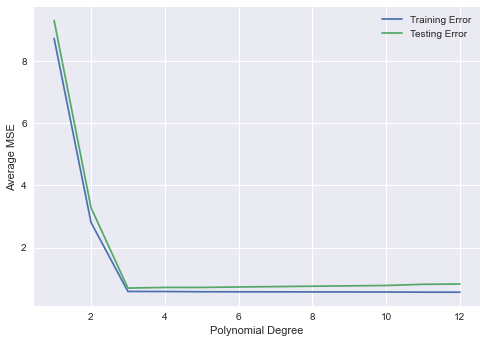

   Degree  Training Error  Testing Error
0       1        8.722051       9.301446
1       2        2.807400       3.282010
2       3        0.589526       0.697604
3       4        0.587387       0.718279
4       5        0.579579       0.718225
5       6        0.577586       0.733258
6      10        0.571499       0.780935
7      11        0.566617       0.818681
8      12        0.564864       0.828207


In [30]:
# TODO: Perform 5-fold cross-validation for each polynomial degree.  
#       Keep track of average training/test error for each degree; 
#       Plot results in a single table, properly labeled, and also
#       print out the results in some clear tabular format.

error_list = []
errors = []
degrees = [1,2,3,4,5,6,10,11,12]

k = 5
x_folds, y_folds = make_folds(k)

for d in degrees:
    for i in range(k):
        training_folds_x = x_folds.copy()
        training_folds_x.pop(i)
        
        training_folds_y = y_folds.copy()
        training_folds_y.pop(i)
        
        poly = PolynomialFeatures(degree = d)
        model = linear_model.LinearRegression()
        
        transformed_x = poly.fit_transform(training_folds_x[0] + training_folds_x[1] + 
                                           training_folds_x[2] + training_folds_x[3])
        training_fold_ys = training_folds_y[0] + training_folds_y[1] + training_folds_y[2] + training_folds_y[3]
        
        
        
        model.fit(transformed_x, training_fold_ys)

        y_training_predict = model.predict(transformed_x)
        y_testing_predict = model.predict(poly.fit_transform(x_folds[i]))

        training_error = mean_squared_error(training_fold_ys, y_training_predict)
        testing_error = mean_squared_error(y_folds[i], y_testing_predict)
        
        errors.append([training_error, testing_error])
    
    error_list.append(errors)
    errors = []
   
avg_errors = []
avg_train_error = 0
avg_test_error = 0

for e in error_list:
    for k in range(5):
        avg_train_error += e[k][0]
        avg_test_error += e[k][1]
    
    avg_train_error /= k
    avg_test_error /= k
    
    avg_errors.append([avg_train_error, avg_test_error])
    avg_train_error = 0
    avg_test_error = 0

train_error_avgs = [x[0] for x in avg_errors]    

plt.plot(degrees, [x[0] for x in avg_errors], label = "Training Error")
plt.plot(degrees, [x[1] for x in avg_errors], label = "Testing Error")
plt.xlabel("Polynomial Degree")
plt.ylabel("Average MSE")
plt.legend()
plt.show()


d = {"Degree": degrees,
     "Training Error": [x[0] for x in avg_errors],
     "Testing Error": [x[1] for x in avg_errors]}
table = pd.DataFrame(d, columns = ["Degree", "Training Error", "Testing Error"])
print(table)


#### 2.3 Discuss the results seen in the plots above

**Discussion:** The results show the average mean squared training and testing error for polynomial models with various degrees. We see that the best results, in other words the lowest training and testing errors, are with the degree-3 model. You can see overfitting occur with more and more magntiude starting from the degree-3 polynomial model to the degree-12 polynomial model. This is evident as the training errors of these models are incredibly close and yet their training errors increase as the degree of the polynomial increases.

### 3. Higher-order polynomials

Results are generated and plotted (as for part 1), for the higher polynomial degrees $d = \{15, 17, 19, 21, 25, 30, 35, 40, 50\}$.

#### 3.1 Plot a grid of prediction results/errors for the higher-order polynomials

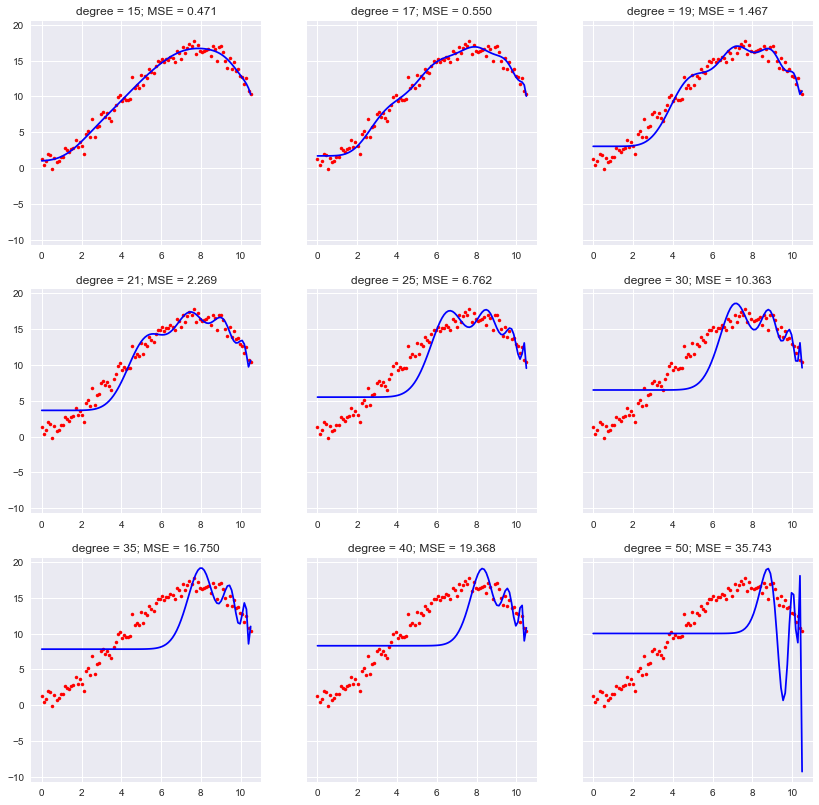

In [31]:
# TODO: generate and plot 9 more models, for the higher-degree polynomials indicated.

prediction_list, error_list = test_polynomials((15, 17, 19, 21, 25, 30, 35, 40, 50))

plot_predictions((15, 17, 19, 21, 25, 30, 35, 40, 50), prediction_list, error_list)

#### 3.2 Discuss the results seen in the plots above

**Discussion**: The results show that as the degree of the polynomial increases higher amnd higher, the model gets worse at making correct, or even close, predictions. I think the models look the way they do because they are very overfit; they try to fit too many individual data points which results in not being able to fit the trend, or most data points.

### 4. Regularized (ridge) regression

Ridge regularization is a process whereby the loss function that is minimized combines the usual measure (error on the training data) with a penalty that is applied to the magnitude of individual coefficients.  This latter penalty discourages models that overly emphasize any single feature, and can often prevent over-fitting.

Here, a set of 50 different `sklearn.linear_model.Ridge` models are generated, each using a single polynomial degree (the one that was determined to be best for the data-set in earlier tests), and using a range of different regularization penalties, chosen from a logarithmic series: $s \in [0.01, 100]$.  5-fold cross-validation is again used to examine how robust these models are.

#### 4.1 Cross-validation for each regularization strength value

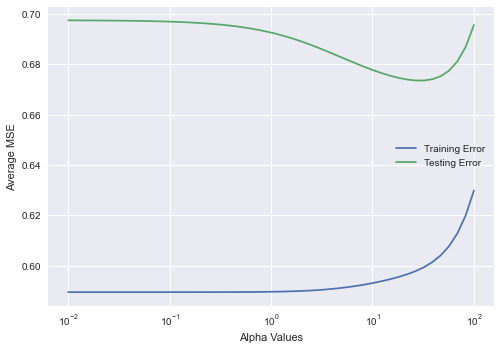

    Alpha Values  Training Error  Testing Error
0       0.010000        0.589526       0.697545
1       0.012068        0.589526       0.697533
2       0.014563        0.589526       0.697518
3       0.017575        0.589526       0.697501
4       0.021210        0.589526       0.697480
5       0.025595        0.589526       0.697454
6       0.030888        0.589526       0.697423
7       0.037276        0.589526       0.697386
8       0.044984        0.589526       0.697342
9       0.054287        0.589526       0.697288
10      0.065513        0.589527       0.697224
11      0.079060        0.589527       0.697146
12      0.095410        0.589527       0.697054
13      0.115140        0.589528       0.696942
14      0.138950        0.589529       0.696809
15      0.167683        0.589531       0.696650
16      0.202359        0.589533       0.696460
17      0.244205        0.589536       0.696234
18      0.294705        0.589541       0.695966
19      0.355648        0.589548       0

In [32]:
# TODO: Generate a sequence of 50 ridge models, varying the regularization strength
#       from 0.01 (10^-2) to 100 (10^2).  Each model is 5-fold cross-validated and
#       the resulting average training/test errors are tracked.  Errors are then
#       plotted (on a logarithmic scale) and printed in some legible tabular form.


error_list = []
errors = []

k = 5
d = 3
x_folds, y_folds = make_folds(k)
alphas = np.logspace(-2, 2, base=10, num=50)

for a in alphas:
    for i in range(k):
        training_folds_x = x_folds.copy()
        training_folds_x.pop(i)
        
        training_folds_y = y_folds.copy()
        training_folds_y.pop(i)

        poly = PolynomialFeatures(degree = d)
        model = linear_model.Ridge(alpha = a)

        transformed_x = poly.fit_transform(training_folds_x[0] + training_folds_x[1] + 
                                           training_folds_x[2] + training_folds_x[3])
        training_fold_ys = training_folds_y[0] + training_folds_y[1] + training_folds_y[2] + training_folds_y[3]



        model.fit(transformed_x, training_fold_ys)
        
        y_training_predict = model.predict(transformed_x)
        y_testing_predict = model.predict(poly.fit_transform(x_folds[i]))
        
        training_error = mean_squared_error(training_fold_ys, y_training_predict)
        testing_error = mean_squared_error(y_folds[i], y_testing_predict)
        
        errors.append([training_error, testing_error])
    
    error_list.append(errors)
    errors = []


avg_errors = []
avg_train_error = 0
avg_test_error = 0

for e in error_list:
    for k in range(5):
        avg_train_error += e[k][0]
        avg_test_error += e[k][1]
    
    avg_train_error /= k
    avg_test_error /= k
    
    avg_errors.append([avg_train_error, avg_test_error])
    avg_train_error = 0
    avg_test_error = 0
    
plt.plot(alphas, [x[0] for x in avg_errors], label = "Training Error")
plt.plot(alphas, [x[1] for x in avg_errors], label = "Testing Error")
plt.xlabel("Alpha Values")
plt.ylabel("Average MSE")
plt.legend()
plt.xscale('log')
plt.show()

d = {"Alpha Values": alphas,
     "Training Error": [x[0] for x in avg_errors],
     "Testing Error": [x[1] for x in avg_errors]}
table = pd.DataFrame(d, columns = ["Alpha Values", "Training Error", "Testing Error"])
print(table)


#### 4.2 Discuss the results seen in the plots above

**Discussion**:  The results show that the effect of increasing regularization is heplful in avoiding for overfitting for alpha values in the range [0.1, 10]. Starting from alpha values near 0.1 to 1, you can see that the training error barely changes while the testing error gradually decreases. For alpha values near 1 to 10, the training starts to increases slightly, but the testing error decreases drastically. When the alpha value is about 50, the lowest testing error is achieved but the training error is slightly greater than it was for lower alpha values. The effect of increasing regularization is less effective for large alpha values, namely from about 50 to 100, because both the training and testing errors drastically increase very quickly.